# **Markov chains Mini-project**



In [11]:
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
np.random.seed(42)

## **MCMC simulation**

In [12]:

class FastBoard:
    def __init__(self, N, board=None):
        self.N = N
        self.energies = []
        
        if board is not None:
            self.board = board.copy()
        else:
            #self.board = np.random.randint(0, N, size=(N, N))
            self.board = np.zeros((N, N), dtype=int)
        self.offset = N
        self.counters = {
            'row_x': np.zeros((N, N), dtype=int),
            'row_y': np.zeros((N, N), dtype=int),
            'diag_xy_sum': np.zeros((N, 2*N), dtype=int),
            'diag_xy_diff': np.zeros((N, 2*N), dtype=int),
            'diag_xz_sum': np.zeros((N, 2*N), dtype=int),
            'diag_xz_diff': np.zeros((N, 2*N), dtype=int),
            'diag_yz_sum': np.zeros((N, 2*N), dtype=int),
            'diag_yz_diff': np.zeros((N, 2*N), dtype=int),
            'space_1': np.zeros((2*N, 2*N), dtype=int),
            'space_2': np.zeros((2*N, 2*N), dtype=int),
            'space_3': np.zeros((2*N, 2*N), dtype=int),
            'space_4': np.zeros((2*N, 2*N), dtype=int),
        }
        
        self.current_energy = 0
        self._compute_initial_energy()
        self.energies.append(self.current_energy)

    def convert(self):
        coords = []
        for x in range(self.N):
            for y in range(self.N):
                z = self.board[x,y]
                coords.append((int(x), int(y), int(z)))
        return coords


    def step(self, temperature, n=1):
        """
        Performs n Metropolis-Hastings steps.
        """
        if isinstance(temperature, (int, float)):
            temps = [temperature] * n
        else:
            temps = temperature

        for i in range(n):
            x = np.random.randint(self.N)
            y = np.random.randint(self.N)
            current_z = self.board[x, y]
            new_z = np.random.randint(self.N)

            if current_z == new_z:
                self.energies.append(self.current_energy)
                continue

            dE_remove = self._get_energy_change(x, y, current_z, -1) 
            dE = self._calculate_transition_delta(x, y, current_z, new_z)


            if dE < 0 or np.random.rand() < np.exp(-dE / temps[i]):
                self._update_counters(x, y, current_z, -1)
                self._update_counters(x, y, new_z, 1)
                self.board[x, y] = new_z
                self.current_energy += dE

            self.energies.append(self.current_energy)

    def _calculate_transition_delta(self, x, y, old_z, new_z):
        """
        Calculates dE without modifying state.
        dE = (Cost of new pos) - (Cost of old pos)
        """
        loss = self._sum_conflicts(x, y, old_z) - 12
        gain = self._sum_conflicts(x, y, new_z)
        return gain - loss

    def _sum_conflicts(self, x, y, z):
        """Returns total queens sharing lines with (x,y,z) from current counters."""
        off = self.offset
        total = 0
        total += self.counters['row_x'][y, z]
        total += self.counters['row_y'][x, z]
        total += self.counters['diag_xy_sum'][z, x + y]
        total += self.counters['diag_xy_diff'][z, x - y + off]
        total += self.counters['diag_xz_sum'][y, x + z]
        total += self.counters['diag_xz_diff'][y, x - z + off]
        total += self.counters['diag_yz_sum'][x, y + z]
        total += self.counters['diag_yz_diff'][x, y - z + off]
        total += self.counters['space_1'][x - y + off, y - z + off]
        total += self.counters['space_2'][x - y + off, y + z]
        total += self.counters['space_3'][x + y, y - z + off]
        total += self.counters['space_4'][x + y, y + z]
        return total

    def _update_counters(self, x, y, z, delta):
        """Updates internal counters when a queen is added (+1) or removed (-1)."""
        off = self.offset
        self.counters['row_x'][y, z] += delta
        self.counters['row_y'][x, z] += delta
        self.counters['diag_xy_sum'][z, x + y] += delta
        self.counters['diag_xy_diff'][z, x - y + off] += delta
        self.counters['diag_xz_sum'][y, x + z] += delta
        self.counters['diag_xz_diff'][y, x - z + off] += delta
        self.counters['diag_yz_sum'][x, y + z] += delta
        self.counters['diag_yz_diff'][x, y - z + off] += delta
        self.counters['space_1'][x - y + off, y - z + off] += delta
        self.counters['space_2'][x - y + off, y + z] += delta
        self.counters['space_3'][x + y, y - z + off] += delta
        self.counters['space_4'][x + y, y + z] += delta

    def _compute_initial_energy(self):
        """One-time expensive setup (O(N^2))."""
        self.current_energy = 0
        for key in self.counters:
            self.counters[key].fill(0)

        for x in range(self.N):
            for y in range(self.N):
                z = self.board[x, y]
                self.current_energy += self._sum_conflicts(x, y, z)
                self._update_counters(x, y, z, 1)
    
    def _get_energy_change(self, x, y, z, delta):
        """Helper to compute energy delta if we add/remove queen at x,y,z."""
        count = self._sum_conflicts(x, y, z)
        if delta == -1: return -(count - 12)
        if delta == 1: return count
        return 0

    def get_3d_board(self):
        """Returns the full NxNxN boolean board for visualization."""
        b = np.zeros((self.N, self.N, self.N), dtype=int)
        for x in range(self.N):
            for y in range(self.N):
                b[x, y, self.board[x, y]] = 1
        return b

## **Further tasks and questions**

### Question 1 

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


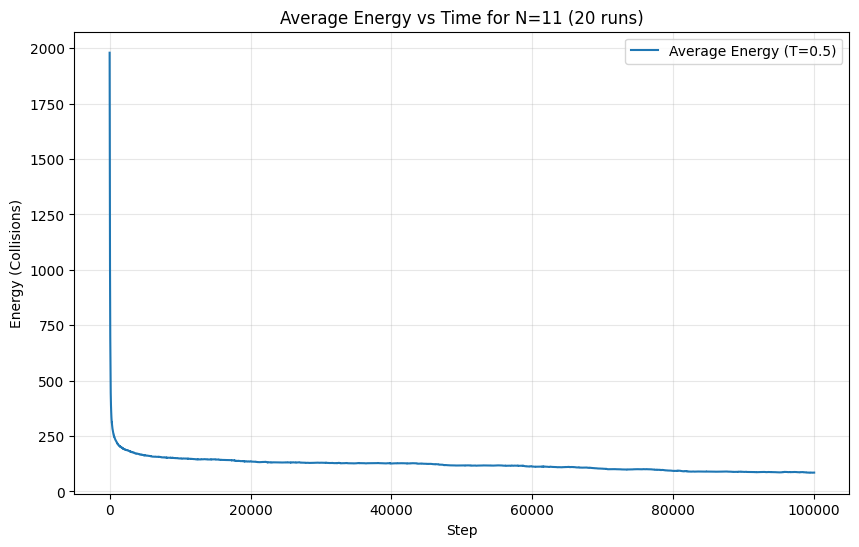

array([1980.  , 1954.15, 1928.2 , ...,   84.85,   84.85,   84.85],
      shape=(100001,))

In [13]:
def average_energy_fixed_T(N, steps, runs=5, temperature=0.5):
    """
    Task 1: For a fixed N, represent the energy as a function of time.
    The energy is averaged across multiple runs (no simulated annealing).
    """

    all_energies = []

    for r in tqdm(range(runs)):
        board = FastBoard(N)
        board.step(temperature, n=steps)
        all_energies.append(board.energies)

    avg_energy = np.mean(np.array(all_energies), axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(avg_energy, label=f"Average Energy (T={temperature})")
    plt.xlabel("Step")
    plt.ylabel("Energy (Collisions)")
    plt.title(f"Average Energy vs Time for N={N} ({runs} runs)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    return avg_energy


average_energy_fixed_T(N=11, steps=100000, runs=20, temperature=0.5)

### Question 2

In [14]:
def run_ensemble(N, steps, temp_schedule, runs=5):
    """
    Runs the simulation 'runs' times and returns the average energy history.
    """
    all_energies = []
    
    for r in tqdm(range(runs)):
        board = FastBoard(N)
        board.step(temp_schedule, n=steps)
        all_energies.append(board.energies)
        
    # Average across runs (axis 0)
    avg_energies = np.mean(np.array(all_energies), axis=0)
    return avg_energies

def average_run(N, steps, runs, t_annealing=None, t_constant=0.5):
    """
    Tasks 1 & 2: Plot Energy vs Time and Compare Annealing vs Constant Temp.
    """
    
    if t_annealing is None:
        t_annealing = np.linspace(3, 0.1, steps)
    else:
        t_annealing = np.linspace(t_annealing[0], t_annealing[1], steps)

    # Run simulations
    print(f"  Simulating Annealing (N={N})...")
    e_anneal = run_ensemble(N, steps, t_annealing, runs=runs)
    
    print(f"  Simulating Constant Temp (N={N})...")
    e_const = run_ensemble(N, steps, t_constant, runs=runs)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(e_anneal, label='Simulated Annealing', color='red')
    plt.plot(e_const, label=f'Constant Temp (T={t_constant})', color='blue', alpha=0.6)
    
    plt.title(f"Average Energy Optimization (N={N}, {runs} runs)")
    plt.xlabel("Step")
    plt.ylabel("Energy (Collisions)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_N(n_values, steps, repeats=10, t_schedule=None, title="linear"):
    """
    Tasks 3 & 4: Minimal Energy vs N.
    """

    min_energies = []
    if t_schedule is None:
        t_schedule = np.linspace(5, 0.5, steps)
    
    for N in tqdm(n_values, desc="Testing N sizes"):
        best_e_for_N = float('inf')
        for _ in range(repeats):
            board = FastBoard(N)
            board.step(t_schedule, n=steps)
            if min(board.energies) < best_e_for_N:
                best_e_for_N = min(board.energies)
            if best_e_for_N == 0:
                solution = board.convert()
                print(f"Solution des N^2 reines pour N = {N} : {solution}")
                break
        print(f"  N={N}, Best Energy Found: {best_e_for_N}")
        min_energies.append(best_e_for_N)
    plt.figure(figsize=(10, 6))
    plt.plot(n_values, min_energies, marker='o', linestyle='-', color='purple')
    
    zeros = [n for n, e in zip(n_values, min_energies) if e == 0]
    if zeros:
        print(f"Perfect solutions found for N = {zeros}")
        
    plt.title(f"Minimal Energy Reached vs. Board Size N with {title} annealing")
    plt.xlabel("N (Board Size NxNxN)")
    plt.ylabel("Minimal Energy Found")
    plt.xticks(n_values)
    plt.grid(True, alpha=0.3)
    
    plt.show()

In [15]:
def make_linear_schedule(T0, T1, steps):
    return np.linspace(T0, T1, steps)

def make_polynomial_schedule(T0, T1, steps, power=2):
    x = np.linspace(0, 1, steps)
    return T0 + (T1 - T0) * (x ** power)

def make_exponential_schedule(T0, T1, steps):
    return T0 * (T1 / T0) ** (np.linspace(0, 1, steps))

def make_batch_schedule(T0, T1, steps, batches=5):
    temps = []
    batch_size = steps // batches
    delta = (T0 - T1) / batches
    for i in range(batches):
        Ti = T0 - i * delta
        temps += [Ti] * batch_size
    # Complete remaining steps in case of integer mismatch
    while len(temps) < steps:
        temps.append(T1)
    return np.array(temps)


Simulating → Constant (T=0.5)


100%|██████████| 50/50 [00:48<00:00,  1.04it/s]


Simulating → Linear


100%|██████████| 50/50 [00:51<00:00,  1.02s/it]


Simulating → Polynomial (power=2)


100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


Simulating → Exponential


100%|██████████| 50/50 [00:47<00:00,  1.05it/s]


Simulating → Batch annealing


100%|██████████| 50/50 [00:52<00:00,  1.04s/it]


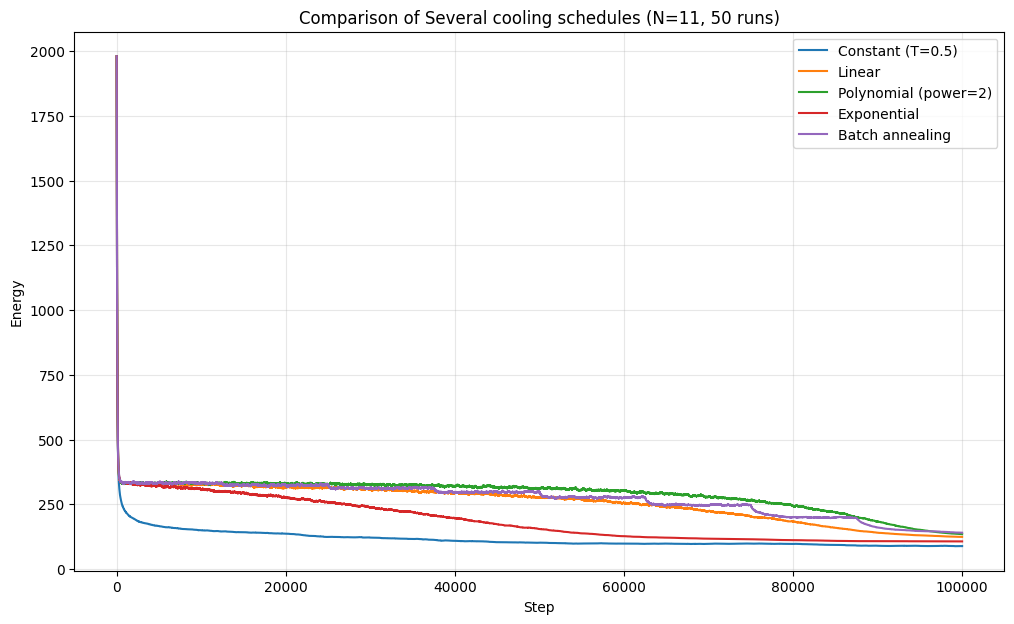

In [16]:


def plot_multiple_schedules(N, steps, runs=10):
    """
    Compare:
      - Constant temperature
      - Linear annealing
      - Polynomial annealing
      - Exponential annealing
      - Batch annealing (piecewise constant)
    """

    schedules = {
        "Constant (T=0.5)": 0.5,
        "Linear": make_linear_schedule(3, 0.1, steps),
        "Polynomial (power=2)": make_polynomial_schedule(3, 0.1, steps, power=2),
        "Exponential": make_exponential_schedule(3, 0.1, steps),
        "Batch annealing": make_batch_schedule(3, 0.1, steps, batches=8),
    }

    plt.figure(figsize=(12, 7))

    for name, schedule in schedules.items():
        print(f"Simulating → {name}")
        energies = run_ensemble(N, steps, schedule, runs=runs)
        plt.plot(energies, label=name)

    plt.title(f"Comparison of Several cooling schedules (N={N}, {runs} runs)")
    plt.xlabel("Step")
    plt.ylabel("Energy")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


plot_multiple_schedules(N=11, steps=100000, runs=50)



### Question 3

Testing N sizes:   6%|▌         | 1/17 [00:20<05:21, 20.08s/it]

  N=3, Best Energy Found: 13


Testing N sizes:  12%|█▏        | 2/17 [00:40<05:06, 20.45s/it]

  N=4, Best Energy Found: 23


Testing N sizes:  18%|█▊        | 3/17 [01:02<04:51, 20.82s/it]

  N=5, Best Energy Found: 34


Testing N sizes:  24%|██▎       | 4/17 [01:24<04:37, 21.33s/it]

  N=6, Best Energy Found: 47


Testing N sizes:  29%|██▉       | 5/17 [01:46<04:20, 21.69s/it]

  N=7, Best Energy Found: 55


Testing N sizes:  35%|███▌      | 6/17 [02:08<03:59, 21.74s/it]

  N=8, Best Energy Found: 56


Testing N sizes:  41%|████      | 7/17 [02:30<03:37, 21.80s/it]

  N=9, Best Energy Found: 57


Testing N sizes:  47%|████▋     | 8/17 [02:52<03:17, 21.94s/it]

  N=10, Best Energy Found: 40


Testing N sizes:  53%|█████▎    | 9/17 [02:56<02:11, 16.46s/it]

Solution des N^2 reines pour N = 11 : [(0, 0, 1), (0, 1, 10), (0, 2, 8), (0, 3, 6), (0, 4, 4), (0, 5, 2), (0, 6, 0), (0, 7, 9), (0, 8, 7), (0, 9, 5), (0, 10, 3), (1, 0, 7), (1, 1, 5), (1, 2, 3), (1, 3, 1), (1, 4, 10), (1, 5, 8), (1, 6, 6), (1, 7, 4), (1, 8, 2), (1, 9, 0), (1, 10, 9), (2, 0, 2), (2, 1, 0), (2, 2, 9), (2, 3, 7), (2, 4, 5), (2, 5, 3), (2, 6, 1), (2, 7, 10), (2, 8, 8), (2, 9, 6), (2, 10, 4), (3, 0, 8), (3, 1, 6), (3, 2, 4), (3, 3, 2), (3, 4, 0), (3, 5, 9), (3, 6, 7), (3, 7, 5), (3, 8, 3), (3, 9, 1), (3, 10, 10), (4, 0, 3), (4, 1, 1), (4, 2, 10), (4, 3, 8), (4, 4, 6), (4, 5, 4), (4, 6, 2), (4, 7, 0), (4, 8, 9), (4, 9, 7), (4, 10, 5), (5, 0, 9), (5, 1, 7), (5, 2, 5), (5, 3, 3), (5, 4, 1), (5, 5, 10), (5, 6, 8), (5, 7, 6), (5, 8, 4), (5, 9, 2), (5, 10, 0), (6, 0, 4), (6, 1, 2), (6, 2, 0), (6, 3, 9), (6, 4, 7), (6, 5, 5), (6, 6, 3), (6, 7, 1), (6, 8, 10), (6, 9, 8), (6, 10, 6), (7, 0, 10), (7, 1, 8), (7, 2, 6), (7, 3, 4), (7, 4, 2), (7, 5, 0), (7, 6, 9), (7, 7, 7), (7, 8, 5), 

Testing N sizes:  59%|█████▉    | 10/17 [03:19<02:08, 18.31s/it]

  N=12, Best Energy Found: 26


Testing N sizes:  65%|██████▍   | 11/17 [03:42<01:58, 19.81s/it]

Solution des N^2 reines pour N = 13 : [(0, 0, 0), (0, 1, 8), (0, 2, 3), (0, 3, 11), (0, 4, 6), (0, 5, 1), (0, 6, 9), (0, 7, 4), (0, 8, 12), (0, 9, 7), (0, 10, 2), (0, 11, 10), (0, 12, 5), (1, 0, 10), (1, 1, 5), (1, 2, 0), (1, 3, 8), (1, 4, 3), (1, 5, 11), (1, 6, 6), (1, 7, 1), (1, 8, 9), (1, 9, 4), (1, 10, 12), (1, 11, 7), (1, 12, 2), (2, 0, 7), (2, 1, 2), (2, 2, 10), (2, 3, 5), (2, 4, 0), (2, 5, 8), (2, 6, 3), (2, 7, 11), (2, 8, 6), (2, 9, 1), (2, 10, 9), (2, 11, 4), (2, 12, 12), (3, 0, 4), (3, 1, 12), (3, 2, 7), (3, 3, 2), (3, 4, 10), (3, 5, 5), (3, 6, 0), (3, 7, 8), (3, 8, 3), (3, 9, 11), (3, 10, 6), (3, 11, 1), (3, 12, 9), (4, 0, 1), (4, 1, 9), (4, 2, 4), (4, 3, 12), (4, 4, 7), (4, 5, 2), (4, 6, 10), (4, 7, 5), (4, 8, 0), (4, 9, 8), (4, 10, 3), (4, 11, 11), (4, 12, 6), (5, 0, 11), (5, 1, 6), (5, 2, 1), (5, 3, 9), (5, 4, 4), (5, 5, 12), (5, 6, 7), (5, 7, 2), (5, 8, 10), (5, 9, 5), (5, 10, 0), (5, 11, 8), (5, 12, 3), (6, 0, 8), (6, 1, 3), (6, 2, 11), (6, 3, 6), (6, 4, 1), (6, 5, 9), 

Testing N sizes:  71%|███████   | 12/17 [04:05<01:44, 20.88s/it]

  N=14, Best Energy Found: 173


Testing N sizes:  76%|███████▋  | 13/17 [04:29<01:26, 21.61s/it]

  N=15, Best Energy Found: 210


Testing N sizes:  82%|████████▏ | 14/17 [04:52<01:06, 22.27s/it]

  N=16, Best Energy Found: 246


Testing N sizes:  88%|████████▊ | 15/17 [05:16<00:45, 22.53s/it]

  N=17, Best Energy Found: 271


Testing N sizes:  94%|█████████▍| 16/17 [05:39<00:22, 22.71s/it]

  N=18, Best Energy Found: 296


Testing N sizes: 100%|██████████| 17/17 [06:02<00:00, 21.31s/it]

  N=19, Best Energy Found: 345
Perfect solutions found for N = [11, 13]


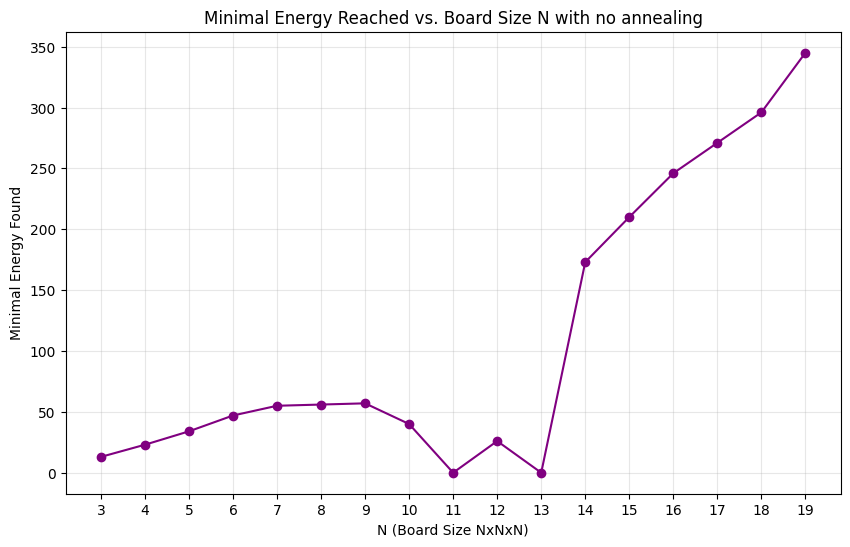

Testing N sizes:   6%|▌         | 1/17 [00:22<06:02, 22.64s/it]

  N=3, Best Energy Found: 13


Testing N sizes:  12%|█▏        | 2/17 [00:46<05:53, 23.55s/it]

  N=4, Best Energy Found: 23


Testing N sizes:  18%|█▊        | 3/17 [01:11<05:36, 24.05s/it]

  N=5, Best Energy Found: 34


Testing N sizes:  24%|██▎       | 4/17 [01:36<05:16, 24.36s/it]

  N=6, Best Energy Found: 47


Testing N sizes:  29%|██▉       | 5/17 [02:01<04:57, 24.77s/it]

  N=7, Best Energy Found: 55


Testing N sizes:  35%|███▌      | 6/17 [02:27<04:34, 24.95s/it]

  N=8, Best Energy Found: 56


Testing N sizes:  41%|████      | 7/17 [02:52<04:11, 25.17s/it]

  N=9, Best Energy Found: 57


Testing N sizes:  47%|████▋     | 8/17 [03:19<03:50, 25.59s/it]

  N=10, Best Energy Found: 41


Testing N sizes:  53%|█████▎    | 9/17 [03:34<02:59, 22.45s/it]

Solution des N^2 reines pour N = 11 : [(0, 0, 6), (0, 1, 4), (0, 2, 2), (0, 3, 0), (0, 4, 9), (0, 5, 7), (0, 6, 5), (0, 7, 3), (0, 8, 1), (0, 9, 10), (0, 10, 8), (1, 0, 1), (1, 1, 10), (1, 2, 8), (1, 3, 6), (1, 4, 4), (1, 5, 2), (1, 6, 0), (1, 7, 9), (1, 8, 7), (1, 9, 5), (1, 10, 3), (2, 0, 7), (2, 1, 5), (2, 2, 3), (2, 3, 1), (2, 4, 10), (2, 5, 8), (2, 6, 6), (2, 7, 4), (2, 8, 2), (2, 9, 0), (2, 10, 9), (3, 0, 2), (3, 1, 0), (3, 2, 9), (3, 3, 7), (3, 4, 5), (3, 5, 3), (3, 6, 1), (3, 7, 10), (3, 8, 8), (3, 9, 6), (3, 10, 4), (4, 0, 8), (4, 1, 6), (4, 2, 4), (4, 3, 2), (4, 4, 0), (4, 5, 9), (4, 6, 7), (4, 7, 5), (4, 8, 3), (4, 9, 1), (4, 10, 10), (5, 0, 3), (5, 1, 1), (5, 2, 10), (5, 3, 8), (5, 4, 6), (5, 5, 4), (5, 6, 2), (5, 7, 0), (5, 8, 9), (5, 9, 7), (5, 10, 5), (6, 0, 9), (6, 1, 7), (6, 2, 5), (6, 3, 3), (6, 4, 1), (6, 5, 10), (6, 6, 8), (6, 7, 6), (6, 8, 4), (6, 9, 2), (6, 10, 0), (7, 0, 4), (7, 1, 2), (7, 2, 0), (7, 3, 9), (7, 4, 7), (7, 5, 5), (7, 6, 3), (7, 7, 1), (7, 8, 10), 

Testing N sizes:  59%|█████▉    | 10/17 [04:00<02:43, 23.43s/it]

  N=12, Best Energy Found: 128


Testing N sizes:  65%|██████▍   | 11/17 [04:26<02:25, 24.17s/it]

  N=13, Best Energy Found: 56


Testing N sizes:  71%|███████   | 12/17 [04:52<02:03, 24.71s/it]

  N=14, Best Energy Found: 180


Testing N sizes:  76%|███████▋  | 13/17 [05:18<01:40, 25.17s/it]

  N=15, Best Energy Found: 216


Testing N sizes:  82%|████████▏ | 14/17 [05:44<01:16, 25.40s/it]

  N=16, Best Energy Found: 240


Testing N sizes:  88%|████████▊ | 15/17 [06:11<00:51, 25.94s/it]

  N=17, Best Energy Found: 273


Testing N sizes:  94%|█████████▍| 16/17 [06:37<00:26, 26.07s/it]

  N=18, Best Energy Found: 313


Testing N sizes: 100%|██████████| 17/17 [07:04<00:00, 24.97s/it]

  N=19, Best Energy Found: 349
Perfect solutions found for N = [11]


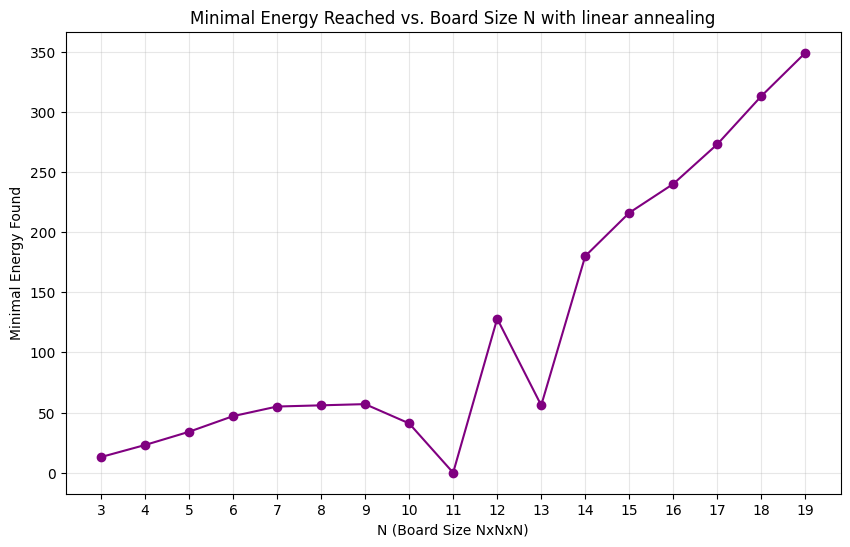

Testing N sizes:   6%|▌         | 1/17 [00:23<06:14, 23.41s/it]

  N=3, Best Energy Found: 13


Testing N sizes:  12%|█▏        | 2/17 [00:48<06:01, 24.12s/it]

  N=4, Best Energy Found: 23


Testing N sizes:  18%|█▊        | 3/17 [01:14<05:50, 25.01s/it]

  N=5, Best Energy Found: 34


Testing N sizes:  24%|██▎       | 4/17 [01:40<05:30, 25.39s/it]

  N=6, Best Energy Found: 48


Testing N sizes:  29%|██▉       | 5/17 [02:06<05:07, 25.62s/it]

  N=7, Best Energy Found: 57


Testing N sizes:  35%|███▌      | 6/17 [02:32<04:44, 25.86s/it]

  N=8, Best Energy Found: 56


Testing N sizes:  41%|████      | 7/17 [02:59<04:21, 26.19s/it]

  N=9, Best Energy Found: 67


Testing N sizes:  47%|████▋     | 8/17 [03:26<03:59, 26.56s/it]

  N=10, Best Energy Found: 93


Testing N sizes:  53%|█████▎    | 9/17 [03:53<03:33, 26.69s/it]

  N=11, Best Energy Found: 112


Testing N sizes:  59%|█████▉    | 10/17 [04:20<03:07, 26.78s/it]

  N=12, Best Energy Found: 132


Testing N sizes:  65%|██████▍   | 11/17 [04:47<02:40, 26.79s/it]

  N=13, Best Energy Found: 165


Testing N sizes:  71%|███████   | 12/17 [05:14<02:13, 26.74s/it]

  N=14, Best Energy Found: 196


Testing N sizes:  76%|███████▋  | 13/17 [05:41<01:47, 26.85s/it]

  N=15, Best Energy Found: 227


Testing N sizes:  82%|████████▏ | 14/17 [06:08<01:20, 26.92s/it]

  N=16, Best Energy Found: 259


Testing N sizes:  88%|████████▊ | 15/17 [06:35<00:53, 27.00s/it]

  N=17, Best Energy Found: 292


Testing N sizes:  94%|█████████▍| 16/17 [07:02<00:27, 27.08s/it]

  N=18, Best Energy Found: 324


Testing N sizes: 100%|██████████| 17/17 [07:29<00:00, 26.46s/it]

  N=19, Best Energy Found: 367


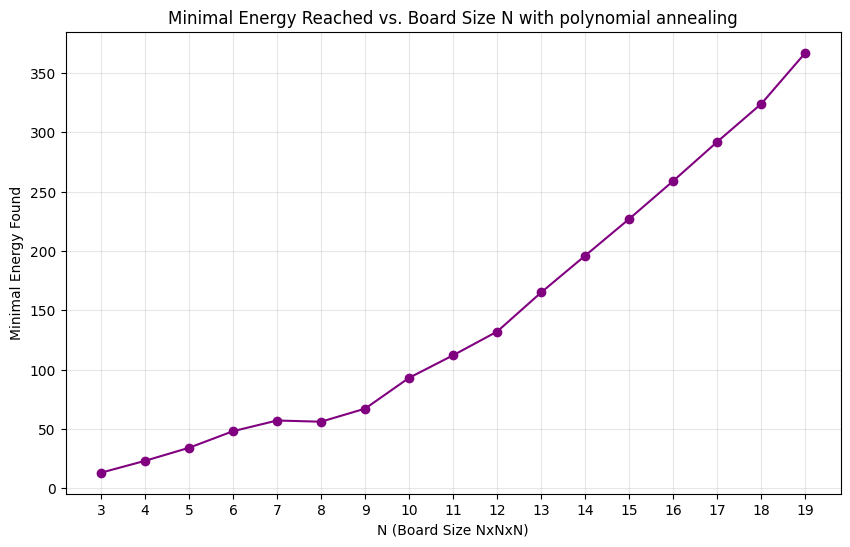

Testing N sizes:   6%|▌         | 1/17 [00:20<05:30, 20.65s/it]

  N=3, Best Energy Found: 13


Testing N sizes:  12%|█▏        | 2/17 [00:42<05:20, 21.40s/it]

  N=4, Best Energy Found: 23


Testing N sizes:  18%|█▊        | 3/17 [01:04<05:01, 21.55s/it]

  N=5, Best Energy Found: 34


Testing N sizes:  24%|██▎       | 4/17 [01:26<04:45, 21.95s/it]

  N=6, Best Energy Found: 47


Testing N sizes:  29%|██▉       | 5/17 [01:50<04:28, 22.38s/it]

  N=7, Best Energy Found: 55


Testing N sizes:  35%|███▌      | 6/17 [02:13<04:10, 22.76s/it]

  N=8, Best Energy Found: 56


Testing N sizes:  41%|████      | 7/17 [02:37<03:50, 23.03s/it]

  N=9, Best Energy Found: 58


Testing N sizes:  47%|████▋     | 8/17 [03:00<03:27, 23.05s/it]

  N=10, Best Energy Found: 39


Testing N sizes:  53%|█████▎    | 9/17 [03:14<02:41, 20.20s/it]

Solution des N^2 reines pour N = 11 : [(0, 0, 10), (0, 1, 3), (0, 2, 7), (0, 3, 0), (0, 4, 4), (0, 5, 8), (0, 6, 1), (0, 7, 5), (0, 8, 9), (0, 9, 2), (0, 10, 6), (1, 0, 8), (1, 1, 1), (1, 2, 5), (1, 3, 9), (1, 4, 2), (1, 5, 6), (1, 6, 10), (1, 7, 3), (1, 8, 7), (1, 9, 0), (1, 10, 4), (2, 0, 6), (2, 1, 10), (2, 2, 3), (2, 3, 7), (2, 4, 0), (2, 5, 4), (2, 6, 8), (2, 7, 1), (2, 8, 5), (2, 9, 9), (2, 10, 2), (3, 0, 4), (3, 1, 8), (3, 2, 1), (3, 3, 5), (3, 4, 9), (3, 5, 2), (3, 6, 6), (3, 7, 10), (3, 8, 3), (3, 9, 7), (3, 10, 0), (4, 0, 2), (4, 1, 6), (4, 2, 10), (4, 3, 3), (4, 4, 7), (4, 5, 0), (4, 6, 4), (4, 7, 8), (4, 8, 1), (4, 9, 5), (4, 10, 9), (5, 0, 0), (5, 1, 4), (5, 2, 8), (5, 3, 1), (5, 4, 5), (5, 5, 9), (5, 6, 2), (5, 7, 6), (5, 8, 10), (5, 9, 3), (5, 10, 7), (6, 0, 9), (6, 1, 2), (6, 2, 6), (6, 3, 10), (6, 4, 3), (6, 5, 7), (6, 6, 0), (6, 7, 4), (6, 8, 8), (6, 9, 1), (6, 10, 5), (7, 0, 7), (7, 1, 0), (7, 2, 4), (7, 3, 8), (7, 4, 1), (7, 5, 5), (7, 6, 9), (7, 7, 2), (7, 8, 6), (

Testing N sizes:  59%|█████▉    | 10/17 [03:37<02:27, 21.14s/it]

  N=12, Best Energy Found: 113


Testing N sizes:  65%|██████▍   | 11/17 [04:00<02:11, 21.86s/it]

  N=13, Best Energy Found: 136


Testing N sizes:  71%|███████   | 12/17 [04:24<01:52, 22.52s/it]

  N=14, Best Energy Found: 179


Testing N sizes:  76%|███████▋  | 13/17 [04:48<01:31, 22.80s/it]

  N=15, Best Energy Found: 200


Testing N sizes:  82%|████████▏ | 14/17 [05:12<01:09, 23.10s/it]

  N=16, Best Energy Found: 227


Testing N sizes:  88%|████████▊ | 15/17 [05:35<00:46, 23.27s/it]

  N=17, Best Energy Found: 261


Testing N sizes:  94%|█████████▍| 16/17 [05:59<00:23, 23.28s/it]

  N=18, Best Energy Found: 290


Testing N sizes: 100%|██████████| 17/17 [06:22<00:00, 22.49s/it]

  N=19, Best Energy Found: 323
Perfect solutions found for N = [11]


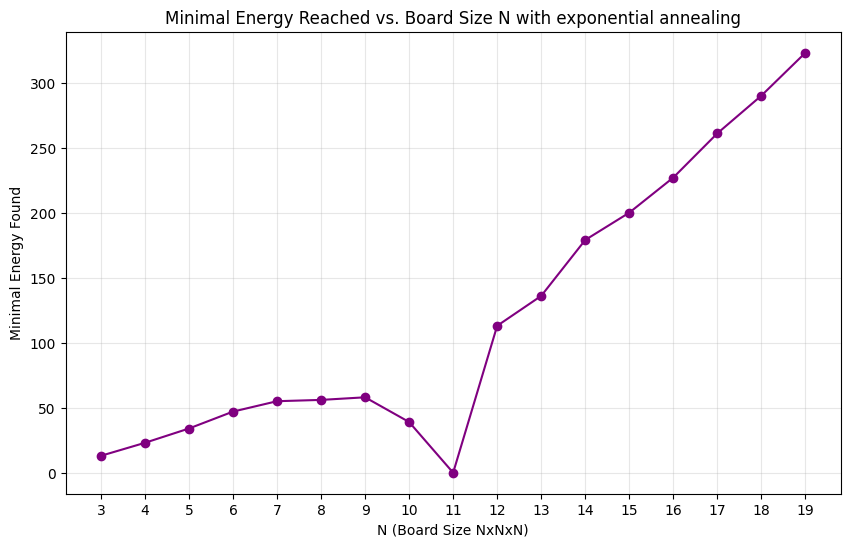

Testing N sizes:   6%|▌         | 1/17 [00:22<05:54, 22.18s/it]

  N=3, Best Energy Found: 13


Testing N sizes:  12%|█▏        | 2/17 [00:45<05:43, 22.88s/it]

  N=4, Best Energy Found: 23


Testing N sizes:  18%|█▊        | 3/17 [01:09<05:27, 23.38s/it]

  N=5, Best Energy Found: 34


Testing N sizes:  24%|██▎       | 4/17 [01:33<05:08, 23.77s/it]

  N=6, Best Energy Found: 49


Testing N sizes:  29%|██▉       | 5/17 [01:58<04:48, 24.02s/it]

  N=7, Best Energy Found: 56


Testing N sizes:  35%|███▌      | 6/17 [02:22<04:26, 24.19s/it]

  N=8, Best Energy Found: 56


Testing N sizes:  41%|████      | 7/17 [02:47<04:04, 24.42s/it]

  N=9, Best Energy Found: 58


Testing N sizes:  47%|████▋     | 8/17 [03:12<03:41, 24.60s/it]

  N=10, Best Energy Found: 41


Testing N sizes:  53%|█████▎    | 9/17 [03:32<03:05, 23.21s/it]

Solution des N^2 reines pour N = 11 : [(0, 0, 9), (0, 1, 2), (0, 2, 6), (0, 3, 10), (0, 4, 3), (0, 5, 7), (0, 6, 0), (0, 7, 4), (0, 8, 8), (0, 9, 1), (0, 10, 5), (1, 0, 7), (1, 1, 0), (1, 2, 4), (1, 3, 8), (1, 4, 1), (1, 5, 5), (1, 6, 9), (1, 7, 2), (1, 8, 6), (1, 9, 10), (1, 10, 3), (2, 0, 5), (2, 1, 9), (2, 2, 2), (2, 3, 6), (2, 4, 10), (2, 5, 3), (2, 6, 7), (2, 7, 0), (2, 8, 4), (2, 9, 8), (2, 10, 1), (3, 0, 3), (3, 1, 7), (3, 2, 0), (3, 3, 4), (3, 4, 8), (3, 5, 1), (3, 6, 5), (3, 7, 9), (3, 8, 2), (3, 9, 6), (3, 10, 10), (4, 0, 1), (4, 1, 5), (4, 2, 9), (4, 3, 2), (4, 4, 6), (4, 5, 10), (4, 6, 3), (4, 7, 7), (4, 8, 0), (4, 9, 4), (4, 10, 8), (5, 0, 10), (5, 1, 3), (5, 2, 7), (5, 3, 0), (5, 4, 4), (5, 5, 8), (5, 6, 1), (5, 7, 5), (5, 8, 9), (5, 9, 2), (5, 10, 6), (6, 0, 8), (6, 1, 1), (6, 2, 5), (6, 3, 9), (6, 4, 2), (6, 5, 6), (6, 6, 10), (6, 7, 3), (6, 8, 7), (6, 9, 0), (6, 10, 4), (7, 0, 6), (7, 1, 10), (7, 2, 3), (7, 3, 7), (7, 4, 0), (7, 5, 4), (7, 6, 8), (7, 7, 1), (7, 8, 5), 

Testing N sizes:  59%|█████▉    | 10/17 [03:58<02:46, 23.84s/it]

  N=12, Best Energy Found: 26


Testing N sizes:  65%|██████▍   | 11/17 [04:23<02:25, 24.28s/it]

  N=13, Best Energy Found: 187


Testing N sizes:  71%|███████   | 12/17 [04:48<02:03, 24.62s/it]

  N=14, Best Energy Found: 232


Testing N sizes:  76%|███████▋  | 13/17 [05:14<01:39, 24.86s/it]

  N=15, Best Energy Found: 280


Testing N sizes:  82%|████████▏ | 14/17 [05:39<01:15, 25.06s/it]

  N=16, Best Energy Found: 317


Testing N sizes:  88%|████████▊ | 15/17 [06:05<00:50, 25.22s/it]

  N=17, Best Energy Found: 368


Testing N sizes:  94%|█████████▍| 16/17 [06:30<00:25, 25.33s/it]

  N=18, Best Energy Found: 420


Testing N sizes: 100%|██████████| 17/17 [06:56<00:00, 24.51s/it]

  N=19, Best Energy Found: 480
Perfect solutions found for N = [11]


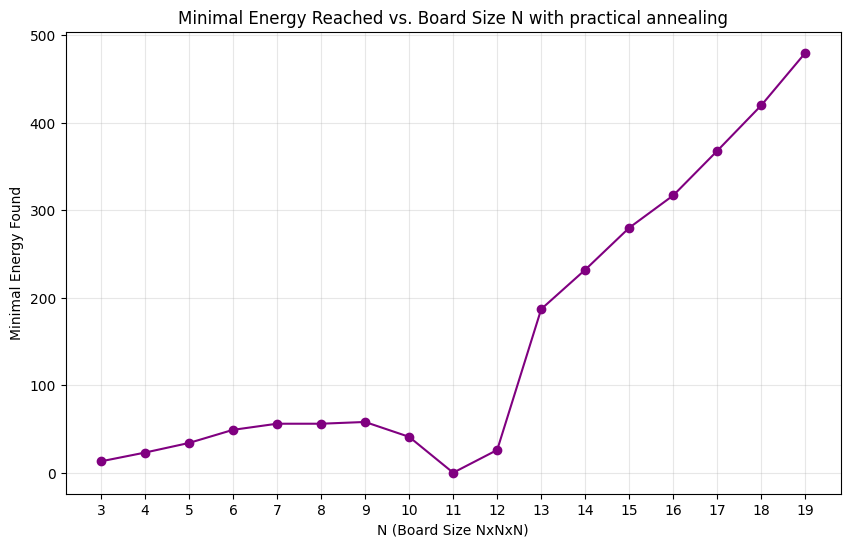

In [ ]:
np.random.seed(21)

steps = 500000
compare_N(range(3,20), steps, 5, t_schedule=0.5, title="no")
compare_N(range(3,20), steps, 5, t_schedule=make_linear_schedule(3, 0.1, steps), title="linear")
compare_N(range(3,20), steps, 5, t_schedule=make_polynomial_schedule(3, 0.1, steps), title="polynomial")
compare_N(range(3,20), steps, 5, t_schedule=make_exponential_schedule(3, 0.1, steps), title="exponential")
compare_N(range(3,20), steps, 5, t_schedule=make_batch_schedule(3, 0.1, steps), title="practical")



### Question 4

> It seems that for N=11 and N=13, the minimal energy is significantly lower than the others.